# Compute change in energy production using expected power analysis

Expected power analysis computes the uplift with uncertainty bounds.  The method is an implementation of that described in [AWC validation methodology](https://publications.tno.nl/publication/34637216/LWOb3s/TNO-2020-R11300.pdf).

In [10]:
from pathlib import Path

import pandas as pd

from flasc.analysis.analysis_input import AnalysisInput
from flasc.analysis.expected_power_analysis import (
    total_uplift_expected_power,
    total_uplift_expected_power_sweep_ws_min,
)
from flasc.analysis.expected_power_analysis_by import (
    total_uplift_expected_power_by_wd,
    total_uplift_expected_power_by_wd_shift_ws_min,
    total_uplift_expected_power_by_ws,
)
from flasc.utilities.floris_tools import estimate_ws_with_floris
from flasc.utilities.utilities_examples import load_floris_smarteole as load_floris

# Load processed data

In [11]:
def load_data():
    root_path = Path.cwd()
    f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.pkl"
    df_scada = pd.read_pickle(f)

    return df_scada


df_scada = load_data()

## Add estimated wind speeds

Use FLORIS and FLASC's `estimate_ws_with_floris` function to estimate the wind speeds.  Because the methods in `expected_power_analysis` don't use reference powers, estimating the wind speed from power is used to provide an improved reference wind speed (versus nacelle anemometer data).

In [12]:
# Add estimated wind speeds using FLORIS model
fm, _ = load_floris("gch", wd_std=0.0)
df_scada = estimate_ws_with_floris(df_scada, fm)

# Prepare data for processing

In [13]:
# Assign wd, ws and pow ref
# Subset dataframe
df_scada = df_scada.assign(
    wd=lambda df_: df_["wd_smarteole"],
    # ws=lambda df_: df_["ws_smarteole"],
)

In [14]:
# Define ws as being based on the estimated wind speeds using the collection of reference turbines
df_scada = df_scada.assign(
    ws=df_scada[["ws_est_000", "ws_est_001", "ws_est_002", "ws_est_006"]].mean(axis=1),
)

In [15]:
# Limit data as in earlier analysis to the region of testing
df_scada = df_scada[df_scada.wd.between(195, 240)]
df_scada = df_scada[df_scada.ws.between(4, 17)]

In [16]:
# Split df_scada into baseline and wake steering on "controlled"
# periods
df_base = df_scada[df_scada.control_mode == "baseline"]
df_con = df_scada[df_scada.control_mode == "controlled"]

In [17]:
# Construct AnalysisInput object using default 1 block since we are not
# bootstrapping
a_in = AnalysisInput([df_base, df_con], ["Baseline", "Controlled"],num_blocks=1)
er_colors = {"Baseline": "black", "Controlled": "red"}

# A note on binning

The `expected_power_analysis` methods do not normalize test power by reference power as for example the `energy_ratio` module does.  In our usage we note a sensitivity to bin configurations and results varying based on those settings.  We find that setting the wind speed bins to a smaller step size (0.5 m/s) then used in other analysis is helpful in reducing sensitivity to other bin parameterization.

# Analysis by wind direction or speed

The underlying algorithm in `expected_power_analysis` is intended to compute the change in energy production across a campaign.  However, because it is useful, several functions for investigating change in energy production by wind direction or wind speed are provided.  The functions operate by looping over the bins and computing the change in energy for the subset of the data that falls within the bin.

## Look at change in energy production by wind direction of the downstream turbine

Investigate the pattern of change in energy production for the downstream turbine (turbine benefitting from wake steering)

(<Figure size 700x300 with 1 Axes>,
 <Axes: xlabel='Wind Direction (Deg)', ylabel='Energy Uplift (%)'>)

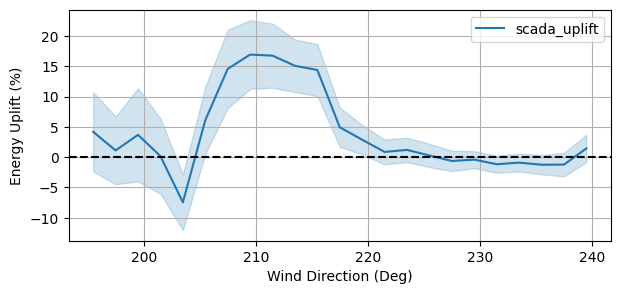

In [22]:
t_wd = total_uplift_expected_power_by_wd(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=4.0,
    ws_step=0.5,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)
t_wd.plot()

A second plot option allows inclusion of distribution information

(<Figure size 700x1000 with 3 Axes>,
 array([<Axes: ylabel='Energy Uplift (%)'>,
        <Axes: xlabel='wd_bin', ylabel='Count'>,
        <Axes: xlabel='Wind Direction (Deg)', ylabel='Wind Speed (m/s)'>],
       dtype=object))

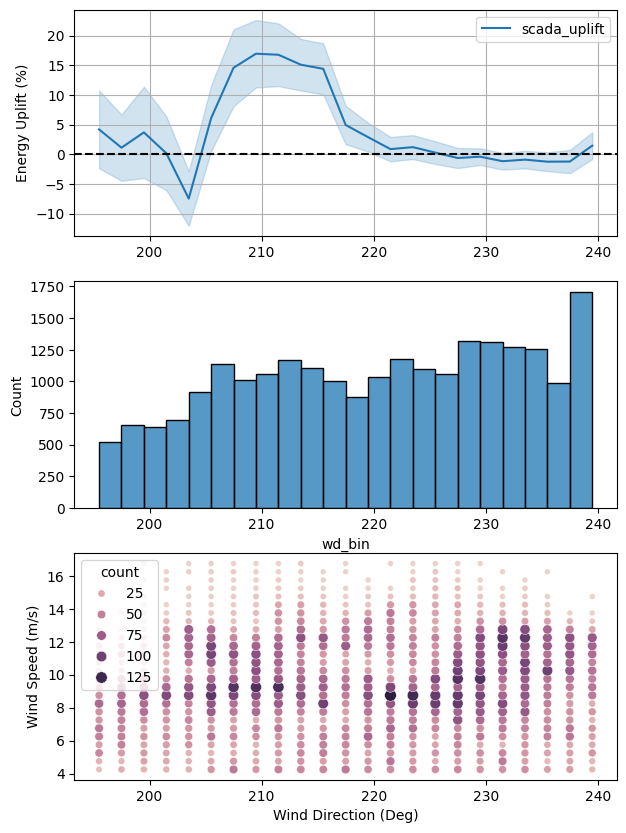

In [23]:
t_wd.plot_with_distributions()

To monitor impact of the bin configuration, some functions are provided to examine impact on results if the wind speed bins are perturbed.  Note at 0.5 m/s bin size, the results are not overly sensitive to the bin configuration.

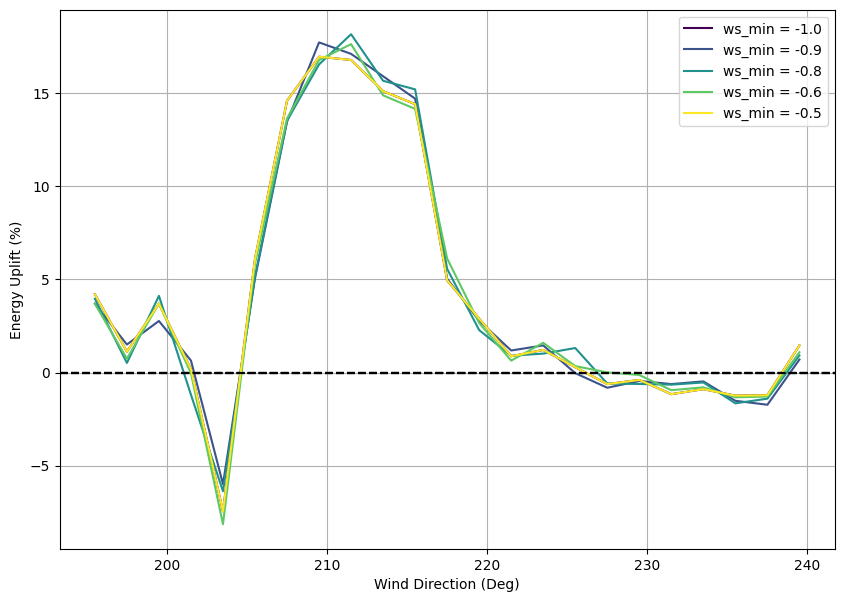

In [24]:
total_uplift_expected_power_by_wd_shift_ws_min(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=-1.0,
    ws_step=0.5,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
    n_step=5,
)

## Look at uplift by wind speed

Uplift of the downstream turbine

(<Figure size 700x300 with 1 Axes>,
 <Axes: xlabel='Wind Speed (m/s)', ylabel='Energy Uplift (%)'>)

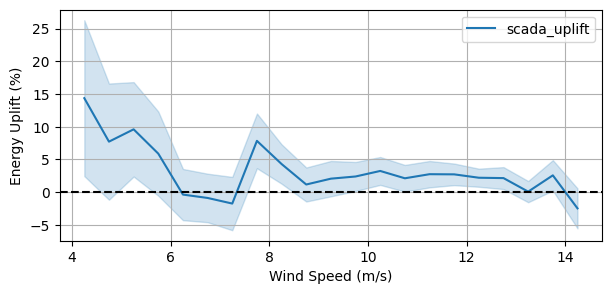

In [30]:
t_ws = total_uplift_expected_power_by_ws(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=4.0,
    ws_step=0.5,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)
t_ws.plot()

(<Figure size 700x1000 with 3 Axes>,
 array([<Axes: ylabel='Energy Uplift (%)'>,
        <Axes: xlabel='ws_bin', ylabel='Count'>,
        <Axes: xlabel='Wind Speed (m/s)', ylabel='Wind Direction (Deg)'>],
       dtype=object))

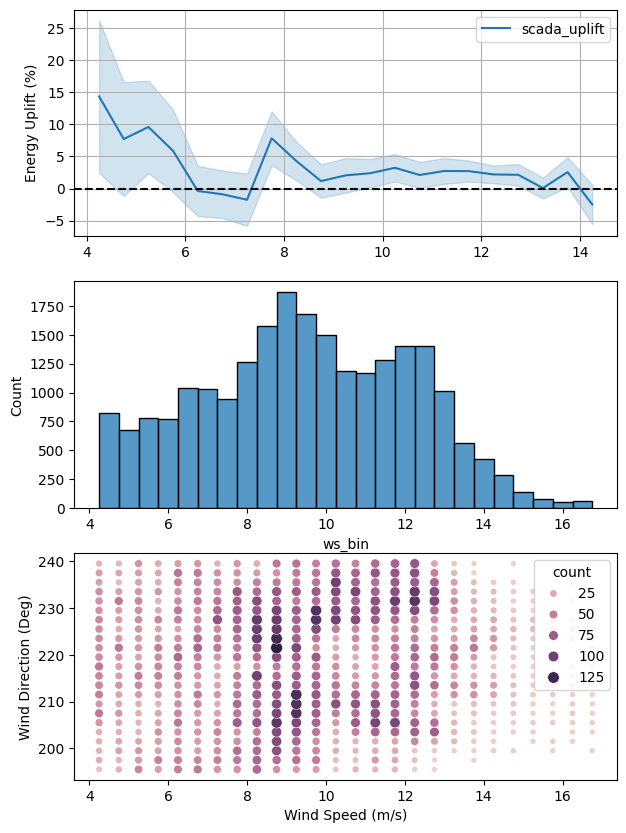

In [31]:
t_ws.plot_with_distributions()

## Compute total uplift

Look at the total uplift of the downstream turbine across the data from the combined upstream and downstream turbines

In [32]:
epao_standard_zero = total_uplift_expected_power(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4, 5],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_min=0.25,
    ws_step=0.5,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)
epao_standard_zero.print_uplift()

+0.45%, (+0.08% - +0.82%) -- N=21502


Note this value can also be sensitive to bin locations so the function below computed the same value with n_step translations, but this sensitivity is limited by choosing an adequately small ws_step.

In [33]:
total_uplift_expected_power_sweep_ws_min(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4, 5],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_min=0.0,
    ws_step=0.5,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
    n_step=10,
)

ws_min: 0.00 --- +0.47%, (+0.10% - +0.84%) -- N=21538
ws_min: 0.06 --- +0.37%, (+0.01% - +0.74%) -- N=21455
ws_min: 0.11 --- +0.40%, (+0.03% - +0.77%) -- N=21495
ws_min: 0.17 --- +0.42%, (+0.06% - +0.79%) -- N=21529
ws_min: 0.22 --- +0.41%, (+0.05% - +0.78%) -- N=21498
ws_min: 0.28 --- +0.39%, (+0.03% - +0.76%) -- N=21492
ws_min: 0.33 --- +0.40%, (+0.03% - +0.76%) -- N=21485
ws_min: 0.39 --- +0.46%, (+0.09% - +0.82%) -- N=21519
ws_min: 0.44 --- +0.41%, (+0.04% - +0.77%) -- N=21561
ws_min: 0.50 --- +0.47%, (+0.10% - +0.84%) -- N=21538
